In [1]:
import pandas as pd
import scipy
import pydicom
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from pathlib import Path
import scipy.stats
import copy
import numpy as np
import pickle

In [2]:
from fastai.basics           import *
from fastai.vision.all       import *
from fastai.medical.imaging  import *

np.set_printoptions(linewidth=120)
matplotlib.rcParams['image.cmap'] = 'bone'
set_seed(42)
set_num_threads(1)

path = Path(r"F:\rsna anant")
path_trn = path/'stage_2_train'
path_dest = path/"output"
path_dest.mkdir(exist_ok=True)

In [3]:
df_lbls = pd.read_csv(r"F:\meta\stage2_train_labels.csv")
df_trn = pd.read_csv(r"F:\rsna anant\stage_2_train_meta.csv").dropna(subset=['img_pct_window'])
comb = df_trn.join(df_lbls.set_index('ID'), 'SOPInstanceUID')

In [4]:
repr_flds = ['BitsStored','PixelRepresentation']
df1 = comb.query('(BitsStored==12) & (PixelRepresentation==0)')
df2 = comb.query('(BitsStored==12) & (PixelRepresentation==1)')
df3 = comb.query('BitsStored==16')
dfs = L(df1,df2,df3)

In [5]:
def df2dcm(df): return [pydicom.dcmread(Path(o)) for o in df.fname.values]

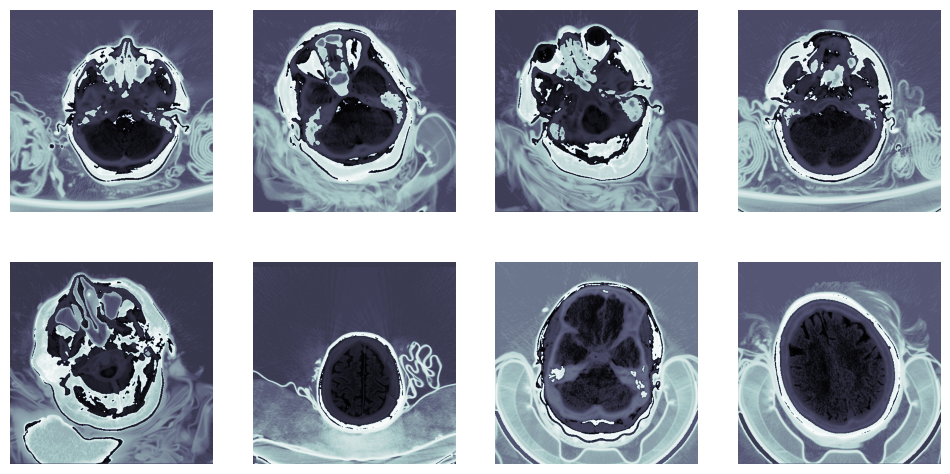

In [6]:
df_iffy = df1[df1.RescaleIntercept>-100]
dcms = df2dcm(df_iffy)

_,axs = subplots(2,4, imsize=3)
for i,ax in enumerate(axs.flat): dcms[i].show(ax=ax)

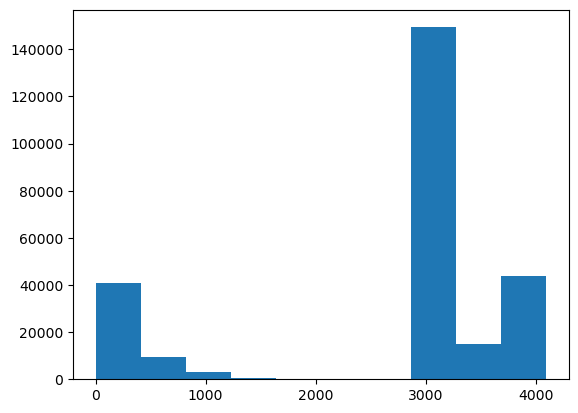

In [7]:
dcm = dcms[2]
d = dcm.pixel_array
plt.hist(d.flatten());

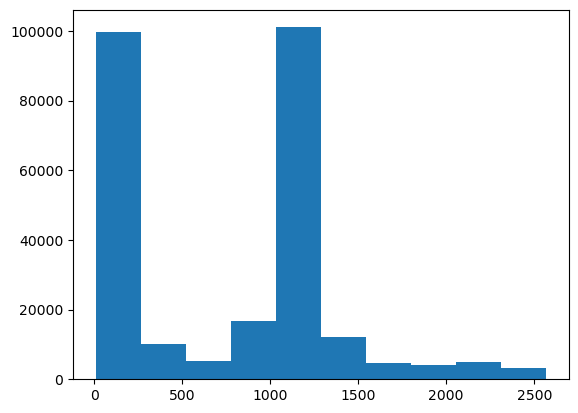

In [8]:
d1 = df2dcm(df1.iloc[[0]])[0].pixel_array
plt.hist(d1.flatten());

In [9]:
mode_value = scipy.stats.mode(d.flatten()).mode
print(mode_value)

3096


In [10]:
# Assuming d is properly defined and manipulated
d += 1000

# Calculate the mode using scipy.stats.mode() and retrieve the scalar mode value
px_mode = scipy.stats.mode(d.flatten()).mode.item()

# Proceed with your operations
d[d >= px_mode] = d[d >= px_mode] - px_mode
dcm.PixelData = d.tobytes()
dcm.RescaleIntercept = -1000

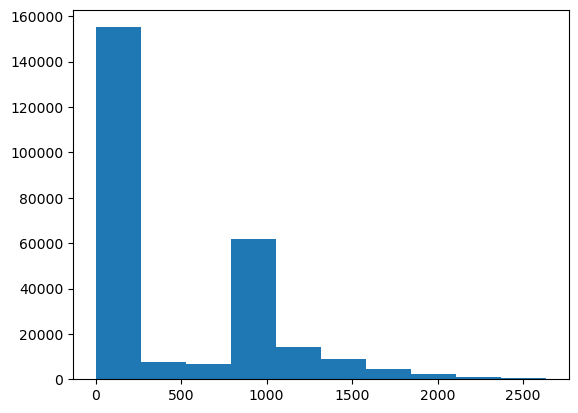

In [11]:
plt.hist(dcm.pixel_array.flatten());

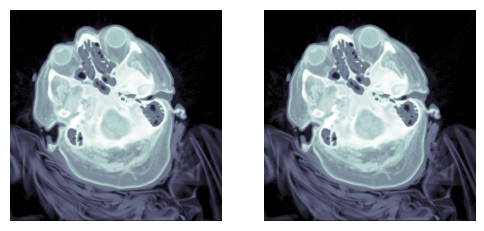

In [12]:
_,axs = subplots(1,2)
dcm.show(ax=axs[0]);   dcm.show(dicom_windows.brain, ax=axs[1])

In [13]:
def fix_pxrepr(dcm):
    if dcm.PixelRepresentation != 0 or dcm.RescaleIntercept<-100: return
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

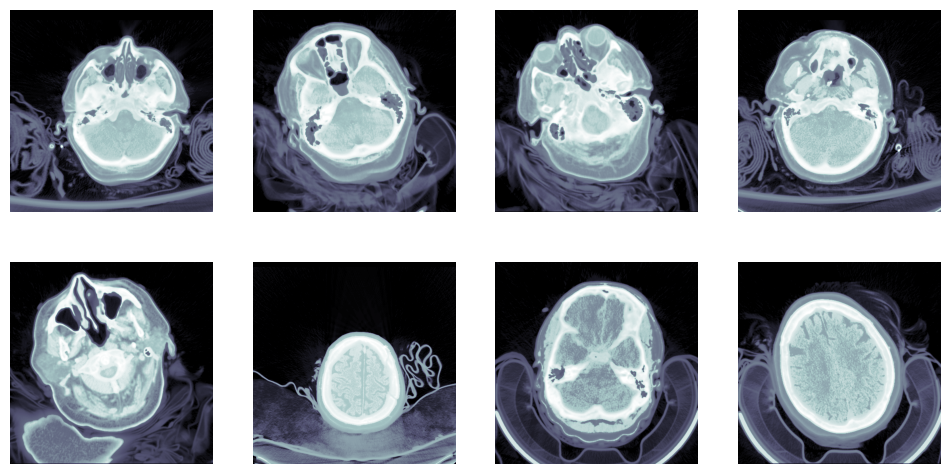

In [14]:
dcms = df2dcm(df_iffy)

# Apply fix_pxrepr to each element in dcms
for dcm in dcms:
    fix_pxrepr(dcm)

# Rest of your code...
_, axs = subplots(2, 4, imsize=3)
for i, ax in enumerate(axs.flat):
    dcms[i].show(ax=ax)

In [15]:
df_iffy.img_pct_window[:10].values

array([0.11207581, 0.14665604, 0.09729385, 0.17225647, 0.12721252, 0.0906105 , 0.24401855, 0.207901  , 0.00475311,
       0.26636124])

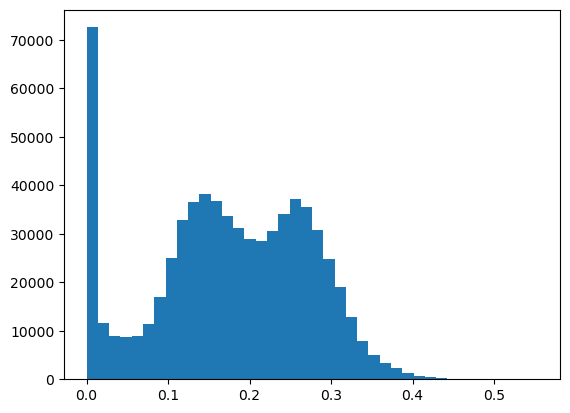

In [16]:
plt.hist(comb.img_pct_window,40);

In [17]:
comb = comb.assign(pct_cut = pd.cut(comb.img_pct_window, [0,0.02,0.05,0.1,0.2,0.3,1]))
comb.pivot_table(values='any', index='pct_cut', aggfunc=['sum','count']).T

,pct_cut,"(0.0, 0.02]","(0.02, 0.05]","(0.05, 0.1]","(0.1, 0.2]","(0.2, 0.3]","(0.3, 1.0]"
sum,any,60,688,3292,21089,55455,16387
count,any,71193,19990,45812,242830,229713,60518


In [18]:
comb.drop(comb.query('img_pct_window<0.02').index, inplace=True)

In [19]:
df_lbl = comb.query('any==True')
n_lbl = len(df_lbl)
n_lbl

96911

In [20]:
df_nonlbl = comb.query('any==False').sample(n_lbl//2)
len(df_nonlbl)

48455

In [21]:
comb = pd.concat([df_lbl,df_nonlbl])
len(comb)

145366

In [22]:
# Assuming comb is your DataFrame
# Save the DataFrame to a CSV file
comb.to_csv(path_dest/'wgt_sample.csv', index=False)

In [23]:
dcm = Path(dcms[3].filename).dcmread()
fix_pxrepr(dcm)

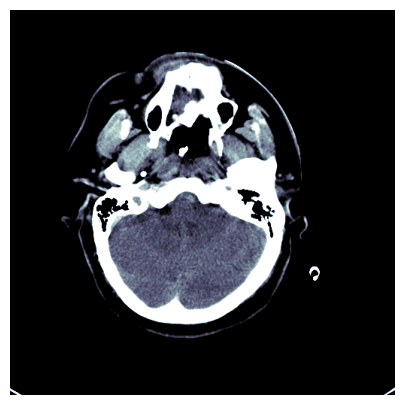

In [24]:
px = dcm.windowed(*dicom_windows.brain)
show_image(px);

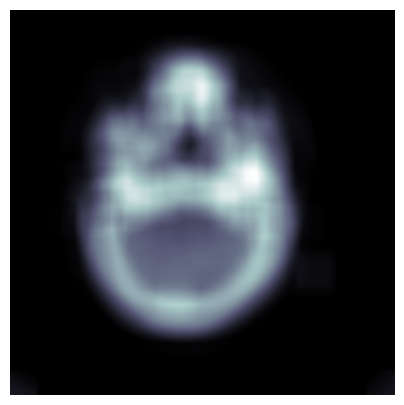

In [25]:
blurred = gauss_blur2d(px, 100)
show_image(blurred);

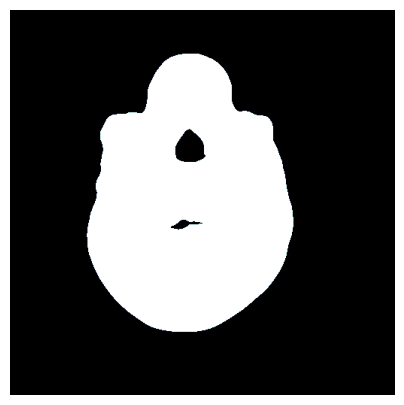

In [26]:
show_image(blurred>0.3);

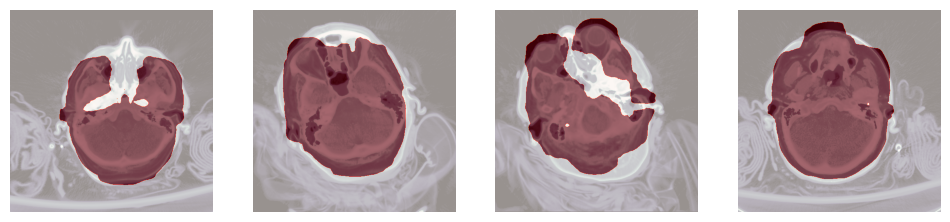

In [27]:
_,axs = subplots(1,4, imsize=3)
for i,ax in enumerate(axs.flat):
    dcms[i].show(dicom_windows.brain, ax=ax)
    show_image(dcms[i].mask_from_blur(dicom_windows.brain), cmap=plt.cm.Reds, alpha=0.6, ax=ax)

In [28]:
def pad_square(x):
    r,c = x.shape
    d = (c-r)/2
    pl,pr,pt,pb = 0,0,0,0
    if d>0: pt,pd = int(math.floor( d)),int(math.ceil( d))        
    else:   pl,pr = int(math.floor(-d)),int(math.ceil(-d))
    return np.pad(x, ((pt,pb),(pl,pr)), 'minimum')

def crop_mask(dcm):
    mask = dcm.mask_from_blur(dicom_windows.brain)
    bb = mask2bbox(mask)
    if bb is None: return
    lo, hi = bb
    cropped = dcm.pixel_array[lo[0]:hi[0], lo[1]:hi[1]]
    padded = pad_square(cropped)
    # Update the pixel data in the DICOM object
    dcm.PixelData = padded.tobytes()
    dcm.Rows, dcm.Columns = padded.shape



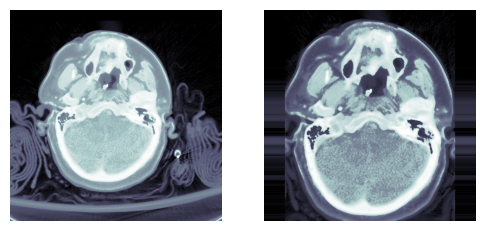

In [29]:
# Test the updated crop_mask function
_, axs = subplots(1, 2)
dcm.show(ax=axs[0])
crop_mask(dcm)
dcm.show(ax=axs[1])


In [30]:
htypes = 'any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural'

def get_samples(df):
    recs = [df.query(f'{c}==1').sample() for c in htypes]
    recs.append(df.query('any==0').sample())
    return pd.concat(recs).fname.values

# Use list comprehension to apply get_samples function to each dataframe in dfs
sample_fns = concat(*[get_samples(df) for df in dfs])
sample_dcms = tuple(Path(o).dcmread().scaled_px for o in sample_fns)
samples = torch.stack(sample_dcms)
bins = samples.freqhist_bins()

In [31]:
# Define the path to save the pickle file
pickle_path = path_dest/'bins.pkl'

# Open the file in write mode and save the bins variable
with open(pickle_path, 'wb') as f:
    pickle.dump(bins, f)

In [32]:
def dcm_tfm(fn): 
    fn = Path(fn)
    try:
        x = fn.dcmread()
        fix_pxrepr(x)
    except Exception as e:
        print(fn,e)
        raise SkipItemException
    if x.Rows != 512 or x.Columns != 512: x.zoom_to((512,512))
    return x.scaled_px

In [33]:
fns = list(comb.fname.values)
dest = path_dest/'train_jpg'
dest.mkdir(exist_ok=True)
# NB: Use bs=512 or 1024 when running on GPU
bs=4

dsrc = Datasets(fns, [[dcm_tfm],[os.path.basename]])
dl = TfmdDL(dsrc, bs=bs, num_workers=2)

In [34]:
def dest_fname(fname, dest): 
    return dest / Path(fname).with_suffix('.jpg')

def save_cropped_jpg(o, dest):
    fname,px = o
    px.save_jpg(dest_fname(fname, dest), [dicom_windows.brain, dicom_windows.subdural], bins=bins)

In [35]:
def process_batch(pxs, fnames, n_workers=4):
    pxs = to_device(pxs)
    masks = pxs.mask_from_blur(dicom_windows.brain)
    bbs = mask2bbox(masks)
    gs = crop_resize(pxs, bbs, 256).cpu().squeeze()
    parallel(save_cropped_jpg, zip(fnames, gs), n_workers=n_workers, progress=False, dest=dest)

In [36]:
# test and time a single batch. It's ~100x faster on a GPU!
%time process_batch(*dl.one_batch(), n_workers=3)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
CPU times: total: 15.6 ms
Wall time: 40.9 ms


In [37]:
fn = dest.ls()[0]
im = Image.open(fn)
fn

Path('F:/rsna anant/output/train_jpg/ID_005da8550.jpg')

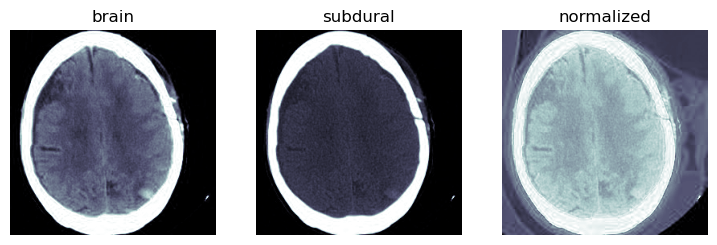

In [38]:
show_images(tensor(im).permute(2,0,1), titles=['brain','subdural','normalized'])

In [39]:
for b in progress_bar(dl): process_batch(*b, n_workers=8)


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 t

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 t

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 t

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 t

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 t

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 t

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 t

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 t

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 t

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 t

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 t

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 t

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 t

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 t

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 t

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 t

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 t

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 t

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 t

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 t

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 t

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 t

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 t

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 t

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 t

KeyboardInterrupt: 

In [ ]:
from PIL import Image

# Uncomment this to view some processed images
for i, (ax, fn) in enumerate(zip(subplots(2, 4, imsize=3)[1].flat, fns)):
    jpgfn = dest/Path(fn).with_suffix('.jpg').name
    a = Image.open(jpgfn)  # Read the JPEG image
    show_image(a, ax=ax)
